In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## STEP 1: COLLECTION (Generate the CSV)

In [5]:
years = [2018, 2019, 2020, 2021, 2022, 2023]
months = [f"{m:02d}" for m in range(1, 13)]
target_rows = 100000
rows_per_file = target_rows // (len(years) * len(months))

all_samples = []

for y in years:
    for m in months:
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{y}-{m}.parquet"
        try:
            df = pd.read_parquet(url, columns=['PULocationID', 'trip_distance', 'fare_amount'])
            sample = df.sample(n=min(rows_per_file, len(df)), random_state=42)
            sample['year'] = y
            all_samples.append(sample)
        except:
            continue

raw_df = pd.concat(all_samples)
raw_df.to_csv("nyc_taxi_raw_100k.csv", index=False)
print("Step 1: Raw CSV Generated.")

Step 1: Raw CSV Generated.


## STEP 2: PREPROCESSING (Cleaning & Filtering)

In [6]:
clean_df = raw_df[(raw_df['trip_distance'] > 0) & (raw_df['fare_amount'] > 0)]

# 2. Outlier Detection (Remove top 1% extreme values)
q_dist = clean_df['trip_distance'].quantile(0.99)
q_fare = clean_df['fare_amount'].quantile(0.99)
clean_df = clean_df[(clean_df['trip_distance'] < q_dist) & (clean_df['fare_amount'] < q_fare)]

# 3. Spatial Aggregation (Points -> Zones)
# This is the "Areal" conversion required for Task 1
spatial_stats = clean_df.groupby('PULocationID').agg({
    'PULocationID': 'count',
    'trip_distance': 'mean',
    'fare_amount': 'mean'
}).rename(columns={'PULocationID': 'pickup_count'}).reset_index()

print("Step 2: Data Cleaned and Aggregated.")

Step 2: Data Cleaned and Aggregated.


## STEP 3: MAPPING (Spatial Join)

In [7]:
zones = gpd.read_file("taxi_zones.shp")
# Fix CRS to NYC Standard (EPSG:2263)
zones = zones.to_crs(epsg=2263)

id_col = 'LocationID' if 'LocationID' in zones.columns else 'location_i'
final_map = zones.merge(spatial_stats, left_on=id_col, right_on='PULocationID', how='left').fillna(0)

print("Step 3: Spatial Join Complete.")

Step 3: Spatial Join Complete.


## STEP 4: EDA (Exploratory Data Analysis)

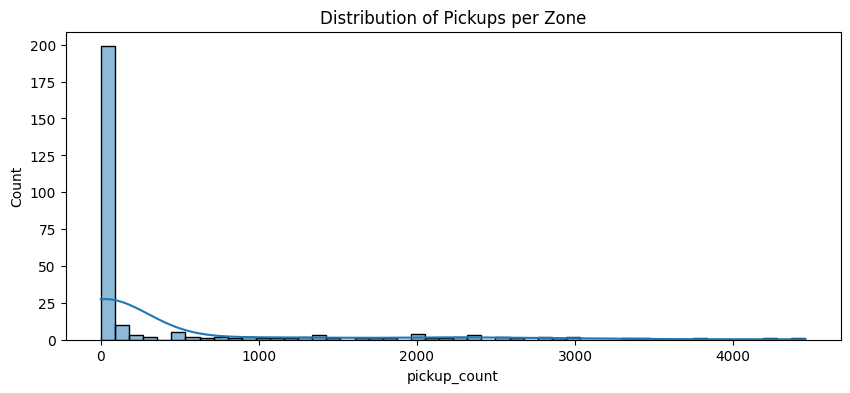

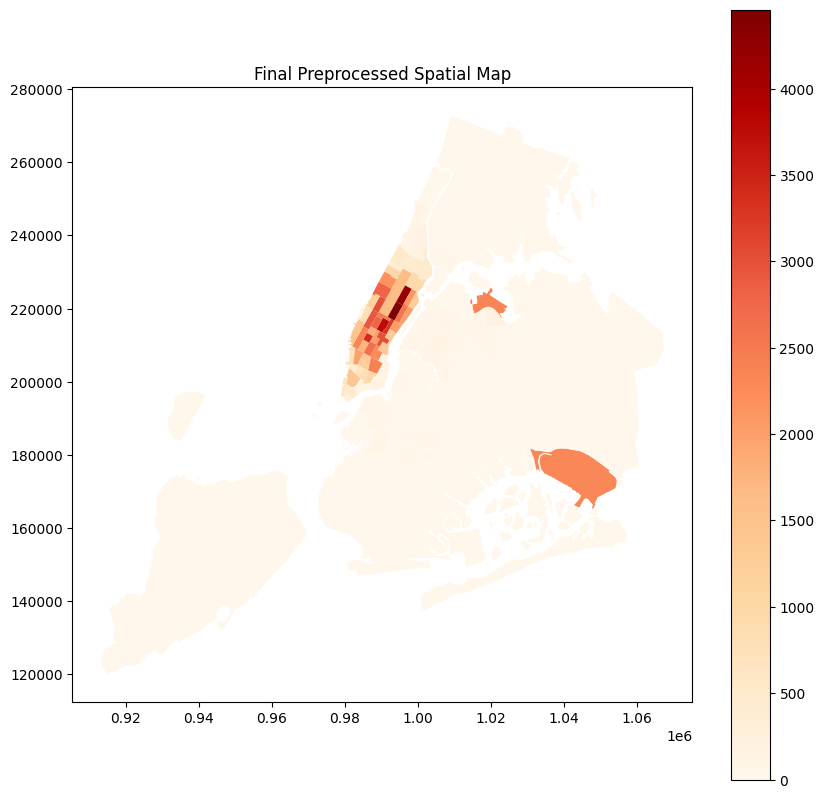

In [8]:
# Plot 1: Histogram of pickups (for Report Task 1)
plt.figure(figsize=(10, 4))
sns.histplot(final_map['pickup_count'], bins=50, kde=True)
plt.title("Distribution of Pickups per Zone")
plt.show()

# Plot 2: The Heatmap (for Report Task 1)
final_map.plot(column='pickup_count', cmap='OrRd', legend=True, figsize=(10, 10))
plt.title("Final Preprocessed Spatial Map")
plt.show()

# Save for Task 2, 3, 4
final_map.to_file("processed_data_for_tasks.geojson", driver='GeoJSON')